In [25]:
import json
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext

# Filtering the videos

We want to study youtube videos related to climate change : the first step is to filter our broad dataset of all videos.
For this, we generated a list of keywords related to climate change :

In [2]:
keywords = {
    'climate change', 'global warming', 'greenhouse gases', 'rising sea levels',
    'extreme weather', 'temperature increase', 'climate action', 
    'carbon emissions', 'renewable energy', 'sustainable living',
    'climate science', 'climate crisis', 'climate adaptation',
    'natural disaster', 'extreme heat', 'melting ice cap', 'sea level rise',
    'biodiversity loss', 'deforestation', 'ocean acidification', 'climate policy', 
    'environmental policy',
    'disaster recovery', 'climate refugees',
    'carbon footprint', 'sustainable development', 'green technology',
    'renewable resource', 'eco-friendly',
    'ecosystem disruption', 'impact on climate',
    'paris agreement', 'climate awareness',
    'environmental justice', 'clean energy', 'zero carbon',
    'green infrastructure', 'ozone layer',
    'pollution', 'water scarcity', 'climate education'
}

keywords2 = {'olympics', 'olympic'}

We create functions to check if a video contains climate change -related keywords in its title, description and tags.

In [3]:
def about_climate(tags):
    tags_set = set(tags)
    return any(tag.strip().lower() in keywords2 for tag in tags_set)

def climate_text(text):
    lowercase_text = text.lower()
    return any(keyword in lowercase_text for keyword in keywords2)

def climate_related(video):
    return (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))

Since the original dataset is huge (97 GB), we read and filter the dataset using pyskark in order to get a reduced dataset with only the relevant videos.

In [ ]:
sc = SparkContext()

In [5]:
path_to_disk = '/Volumes/Maxtor'
path_to_disk_ubuntu = '/media/sebastien/Maxtor'
file_path = '/yt_metadata_en.jsonl'

raw_data = sc.textFile(path_to_disk_ubuntu + file_path)
video_dataset = raw_data.map(lambda x: json.loads(x))

In [6]:
climate_videos = video_dataset.filter(climate_related)
climate_videos_collected = climate_videos.collect()

We save the result in a jsonlines file :

In [7]:
climate_videos_path = "data/climate_videos_new.jsonl"
with jsonlines.open(climate_videos_path, "w") as jsonl_file:
   jsonl_file.write_all(climate_videos_collected)

## Creating new useful features

We count the number of video uploaded each day as well as the views.
This will be useful for our future analysis

In [8]:
video_dataset = video_dataset.filter(lambda x: x['view_count'] is not None and x['upload_date'] is not None)
video_per_date = video_dataset.map(lambda x: (x['upload_date'], x['view_count']))
video_per_date = video_per_date.groupBy(lambda x: x[0]).map(lambda x: (x[0], len(x[1]), sum(map(lambda y: y[1], x[1])))).collect()

ERROR:root:KeyboardInterrupt while sending command.            (710 + 8) / 2911]
Traceback (most recent call last):
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/sebastien/miniconda3/envs/2023/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt
[Stage 0:=============>                                        (711 + 8) / 2911]
KeyboardInterrupt



We save those counts in a json file for later analysis.

In [ ]:
videos_by_date_path = "data/nb_videos_and_views_by_date.jsonl"
with jsonlines.open(videos_by_date_path, "w") as jsonl_file:
    jsonl_file.write_all(video_per_date)
sc.stop()

## First look at our preprocessed dataset :

In [26]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

<Axes: xlabel='categories'>

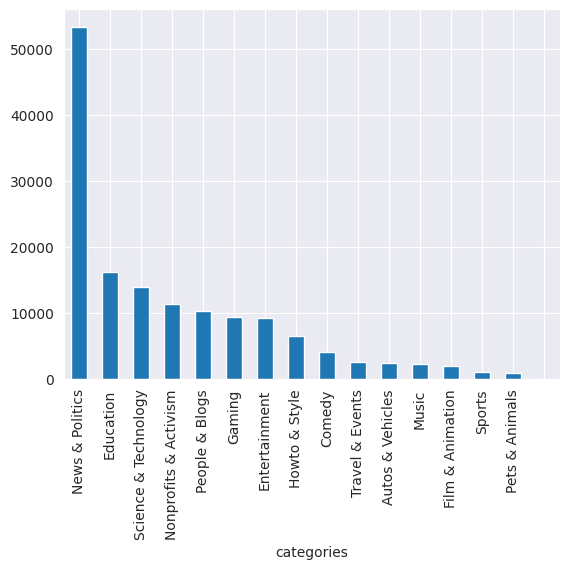

In [27]:
category_counts = climate_videos_df['categories'].value_counts()
category_counts.plot(kind='bar')

We see some suspicious categories : gaming ?

When we look at samples, some titles and descriptions do not seem to correspond to climate change related topics...

Let's go further in the filtering process :

# Filtering refinement

Now that we are working on a more reasonable sized dataset, we can use more complex filtering functions to refine it.

In [28]:
categories = category_counts.reset_index()['categories']

for category in categories:
    print(category)
    print(climate_videos_df[
            climate_videos_df['categories'] == category][
                ['title','description','tags']].head(3))

News & Politics
                                      title  \
204                          GLOBAL WARMING   
205   Al Gore's Paranoia is Getting Worse 😂   
206  Bill Nye: Jail Global Warming Skeptics   

                                           description  \
204  Order your “Liberalism: Find a Cure” or shirts...   
205  CNN had a Town Hall meeting with Al Gore calle...   
206  (((Subscribe))) now for more! http://bit.ly/1Q...   

                                                  tags  
204  2018,Global Warming,Climate Change,Painting St...  
205  Al Gore,Climate Crisis,CNN Town Hall,Al Gore T...  
206  Mark Dice (Person),Bill Nye,Global Warming,Jai...  
Education
                                                 title  \
200  Global warming/ climate change -save planet earth   
342                          Introduction to Economics   
343                       Cap and Trade vs. Carbon Tax   

                                           description  \
200  More than providing entertai

For each channel we count the number of videos related to climate change

In [29]:
channels_path = 'data/df_channels_en.tsv'

counts = climate_videos_df['channel_id'].value_counts().reset_index()
counts.columns = ['channel','count_climate_videos']

channels_df = pd.read_csv(channels_path, delimiter='\t')

channels_df = channels_df.merge(counts, on ='channel', how ='left').fillna(0)
channels_df['proportion_climate_videos'] = channels_df['count_climate_videos']/channels_df['videos_cc']

display(channels_df)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_climate_videos,proportion_climate_videos
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.0870,0.0,0.000000
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.0870,0.0,0.000000
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.0870,7.0,0.000214
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.0870,13.0,0.003620
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.0870,4.0,0.000092
...,...,...,...,...,...,...,...,...,...,...
136465,Music,2016-10-06,UCuM-9AajUOwKw6ipOzu2DRQ,GONE.Fludd - Topic,10128,105,1008139.0,53.1435,0.0,0.000000
136466,People & Blogs,2013-10-17,UCtW9jp5TH0YrgYpwiRf9t-Q,saidthestory,10100,352,1008644.0,53.1435,0.0,0.000000
136467,Gaming,2015-05-08,UCTsxFTIUs8vFDzGccDm6i7Q,Omni H,10000,475,1009505.0,53.1435,0.0,0.000000
136468,Music,2011-04-13,UC1HOArgRCMGPjlcmkThERwA,TĀLĀ,10000,15,1025119.0,53.1435,0.0,0.000000


We look at  ''''' INSERT HIST TITLE '''''

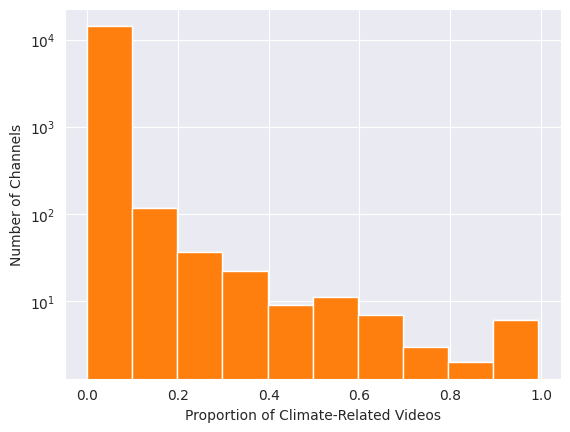

In [30]:
plt.hist(channels_df['proportion_climate_videos'][channels_df['count_climate_videos'] > 0], log = True)
plt.hist(channels_df['proportion_climate_videos'][channels_df['count_climate_videos'] > 0], log = True)
plt.xlabel('Proportion of Climate-Related Videos')
plt.ylabel('Number of Channels')
plt.show()

,upload_date,number_of_videos
0,2005-05-29,1
1,2005-06-05,0
2,2005-06-12,0
3,2005-06-19,0
4,2005-06-26,0
...,...,...
752,2019-10-27,50
753,2019-11-03,31
754,2019-11-10,18
755,2019-11-17,26


,upload_date,count
0,2005-07-17,4
1,2005-07-24,2
2,2005-07-31,0
3,2005-08-07,2
4,2005-08-14,0
...,...,...
741,2019-09-29,1779
742,2019-10-06,462
743,2019-10-13,0
744,2019-10-20,0


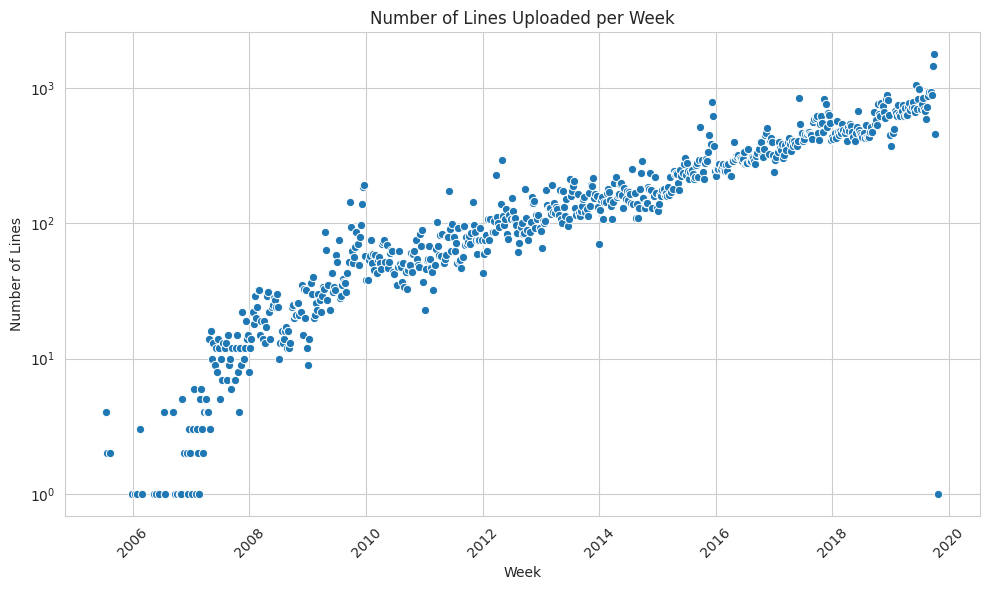

In [31]:
climate_videos_df['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])

weekly_counts_climate = climate_videos_df.groupby(pd.Grouper(key='upload_date', freq='W')).size().reset_index(name='count')

total_number_videos = pd.read_json("data/nb_videos_by_date.jsonl",lines=True)
total_number_videos.columns = ['upload_date','number_of_videos']
total_number_videos['upload_date'] = pd.to_datetime(total_number_videos['upload_date'])

weekly_counts_total = total_number_videos.groupby(pd.Grouper(key='upload_date', freq='W')).sum().reset_index()

display(weekly_counts_total)
display(weekly_counts_climate)

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_counts_climate, x='upload_date', y='count', marker='o', linestyle='')

plt.title('Number of Lines Uploaded per Week')
plt.xlabel('Week')
plt.ylabel('Number of Lines')

plt.xticks(rotation=45)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import json

In [33]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

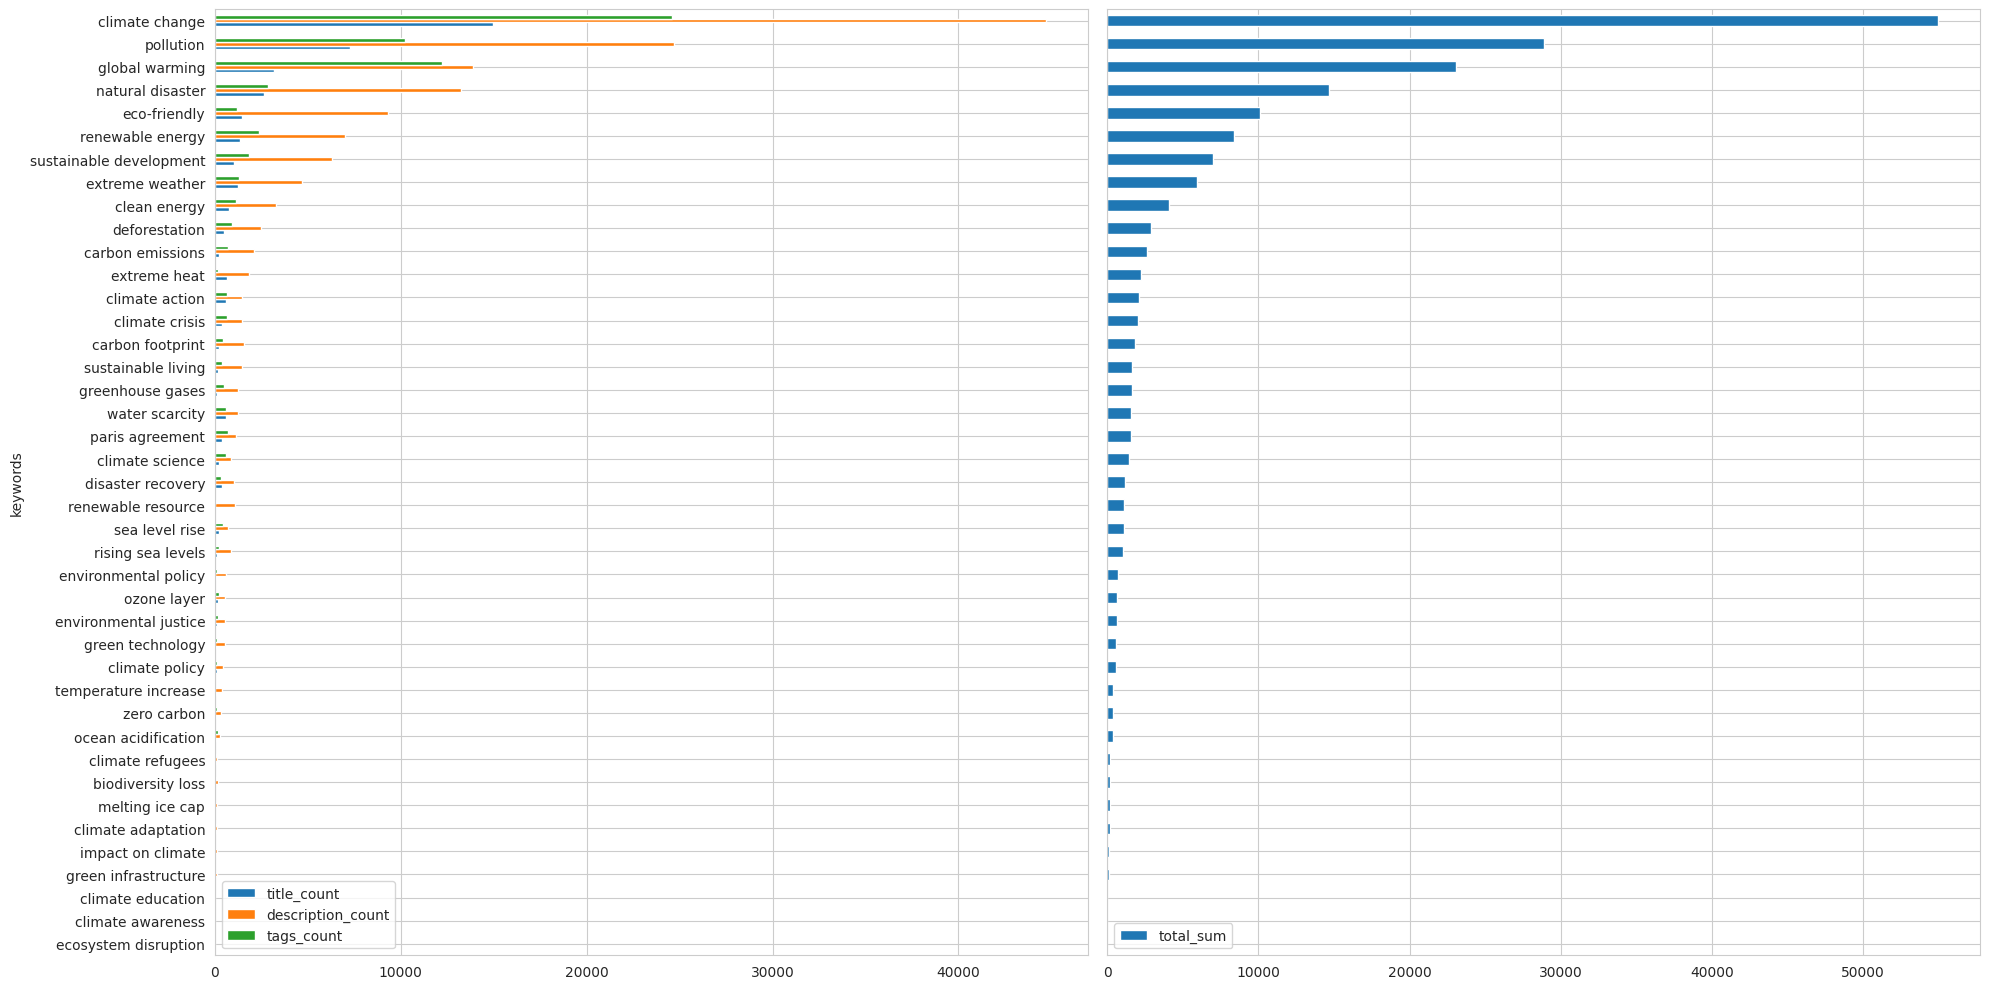

In [34]:
keywords = [
    'climate change', 'global warming', 'greenhouse gases', 'rising sea levels',
    'extreme weather', 'temperature increase', 'climate action', 
    'carbon emissions', 'renewable energy', 'sustainable living',
    'climate science', 'climate crisis', 'climate adaptation',
    'natural disaster', 'extreme heat', 'melting ice cap', 'sea level rise',
    'biodiversity loss', 'deforestation', 'ocean acidification', 'climate policy', 
    'environmental policy',
    'disaster recovery', 'climate refugees',
    'carbon footprint', 'sustainable development', 'green technology',
    'renewable resource', 'eco-friendly',
    'ecosystem disruption', 'impact on climate',
    'paris agreement', 'climate awareness',
    'environmental justice', 'clean energy', 'zero carbon',
    'green infrastructure', 'ozone layer',
    'pollution', 'water scarcity', 'climate education'
]

#keywords = keywords[::5]

keywords_count = pd.DataFrame(columns=['keywords', 'title_count', 'description_count', 'tags_count', 'total_sum'])
keywords_count['keywords'] = keywords
keywords_count.set_index('keywords', inplace=True)

colum_names = ['title', 'description', 'tags']

aug_climate_videos_df = climate_videos_df.copy()

for w in keywords:

    #counts the number of videos that contain the keyword in their metadata
    aug_climate_videos_df['is_' + w] = [1 if w in (climate_videos_df.loc[v, 'title'] + climate_videos_df.loc[v, 'description'] + climate_videos_df.loc[v, 'tags']).lower() else 0 for v in climate_videos_df.index]

    keywords_count.loc[w] = [climate_videos_df[c].str.contains(w, case=False).sum() for c in colum_names] + [aug_climate_videos_df['is_' + w].sum()]

#keywords_count['total_sum'] = keywords_count.sum(axis=1)
keywords_count.sort_values(by=['total_sum'], ascending=True, inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

keywords_count[['title_count', 'description_count', 'tags_count']].plot(kind='barh', ax=ax1)
keywords_count[['total_sum']].plot(kind='barh', ax=ax2)

fig.tight_layout()
plt.show()

#PS: ça prend 1 min a run si on fait pas le count des videos qui contiennent le mot dans leur metadata
#    mais que les counts pour title puis description puis tags

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data

In [36]:
file_path = "data/climate_videos_new.jsonl"
climate_videos_df = pd.read_json(file_path, lines=True)

count_file_path = "data/nb_videos_and_views_by_date.jsonl"
climate_videos_count_df = pd.read_json(count_file_path, lines=True)

# Convert the upload_date column to datetime and set as index

In [37]:
data = climate_videos_df.copy()
data['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])
data = data.set_index('upload_date')
data.sort_index(inplace=True)
data.dropna(inplace=True) # Drop missing values
data.head()

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,view_count
upload_date,,,,,,,,,,,
2005-07-15,Science & Technology,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.046102,The Wouda Steam Pumping Station near Lemmer in...,2.0,Cl-zL3ebFuI,30,6.0,"stockshot,culture,world,heritage,unesco,wereld...",Wouda Steam Pumping Station - Wouda Stoomgemaal,8137.0
2005-07-17,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.959805,Venice is unique in the world: an architectura...,2.0,pB7hdto9Svs,30,3.0,"stockshot,culture,world,heritage,unesco,wereld...","City of Venice, Unesco World Heritage",5671.0
2005-07-17,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.971828,The Grand Canyon is an immense gorge carved by...,2.0,a_se_nXRZaI,30,0.0,"stockshot,culture,world,heritage,unesco,wereld...",Grand Canyon National Park - sunrise,1614.0
2005-07-17,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:08.134007,"The name ""Hohe Tauern"" originally meant ""high ...",0.0,RhB6XeV7pV8,33,4.0,"stockshot,austria,alps,mountians,oostenrijk,na...","Hohe Tauern, Austrian Alps",4527.0
2005-07-18,Travel & Events,UCRuvrextOPCX1MP68hJZTCA,2019-11-03 14:45:05.674465,Wadden Sea National Park is an excellent examp...,4.0,tGTt0Zg8kOY,10,2.0,"stockshot,world,heritage,unesco,werelderfgoed,...",Aerial shots Wadden Sea,2549.0


<Axes: xlabel='upload_date'>

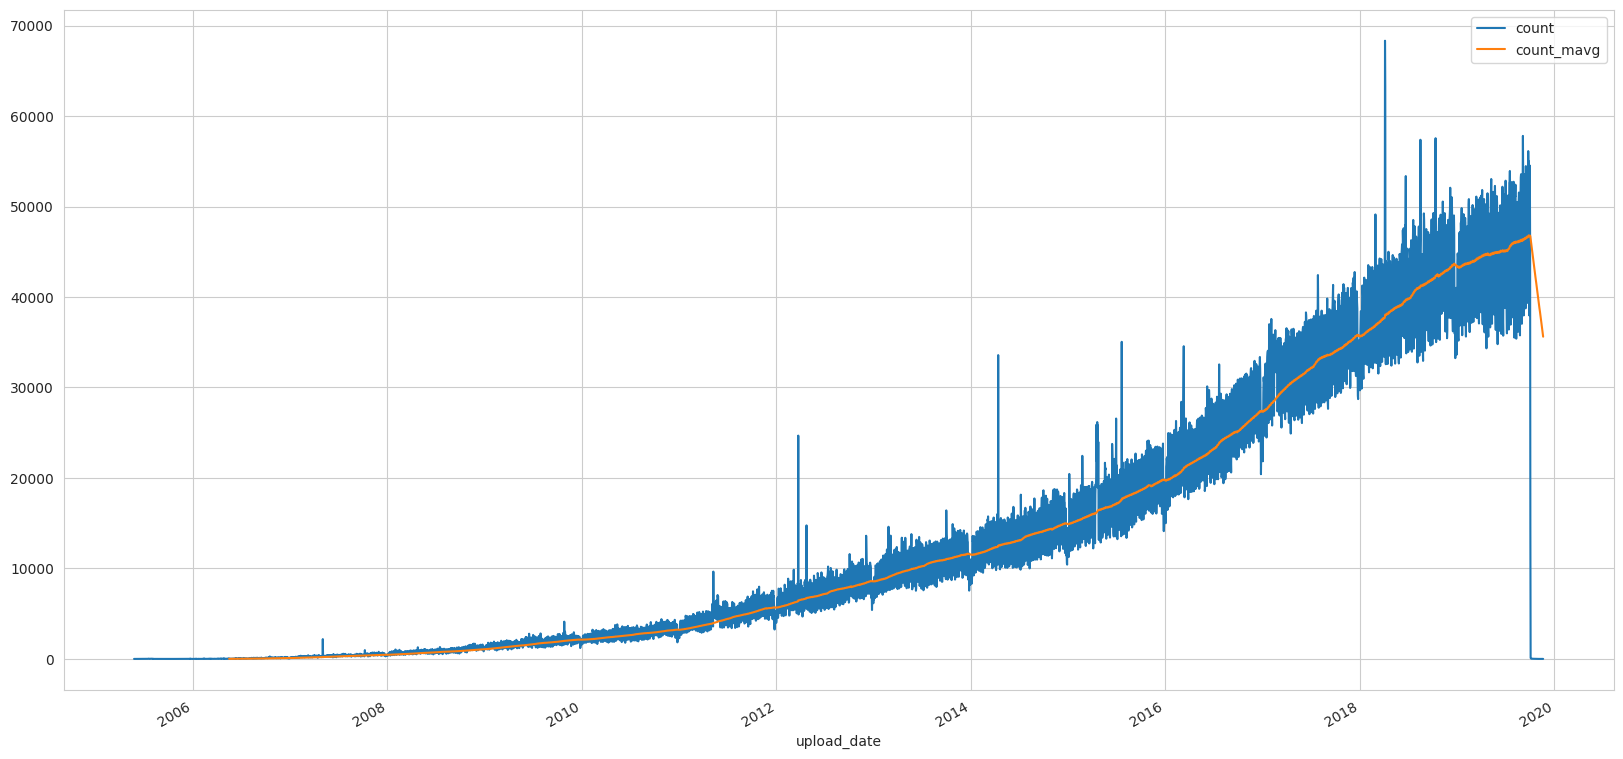

In [38]:
data_count = climate_videos_count_df.copy()
data_count.columns = ['upload_date', 'count', 'views']
data_count.set_index('upload_date', inplace=True)
data_count.index = pd.to_datetime(data_count.index)
data_count.sort_index(inplace=True)

data_count['count_mavg'] = data_count['count'].rolling(window=200).mean()
data_count[['count', 'count_mavg']].plot(figsize=(20, 10))

In [40]:
# Keep the data before the croll date
data_count = data_count['2010':'2019-09-28']
data = data['2010':'2019-09-28']

# Compute the ratio video count and views over time  

In [41]:
# Get video count and views per day
count_per_day = data.groupby(data.index)['view_count'].count()

# Compute the ratio with respect to the total number of videos and views
count_per_day = count_per_day / data_count['count'] * 100
count_per_day.dropna(inplace=True)

# Plot number of videos and views over time 

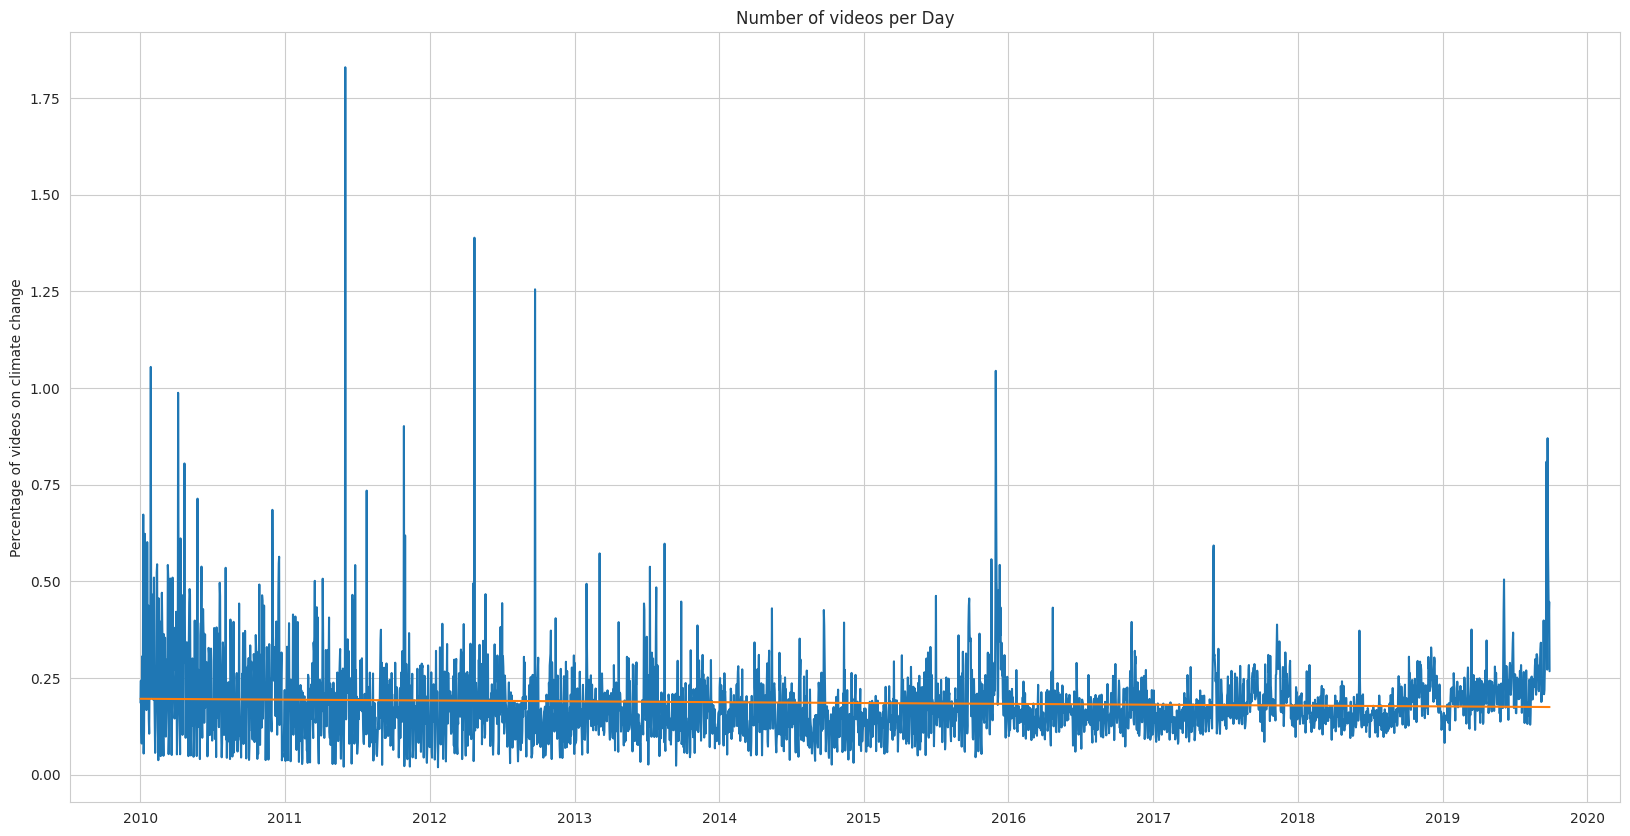

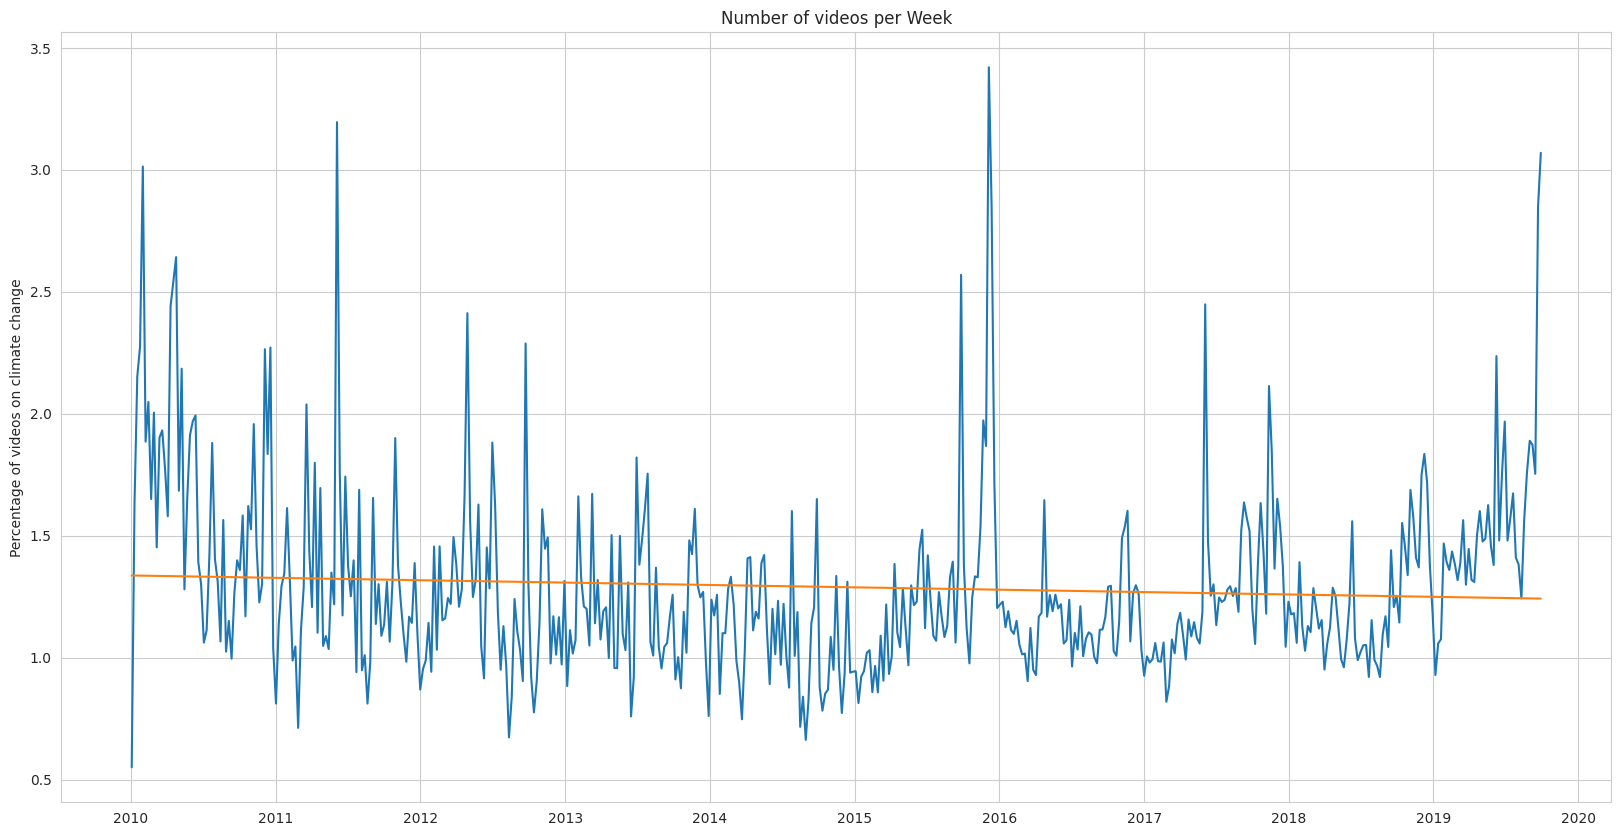

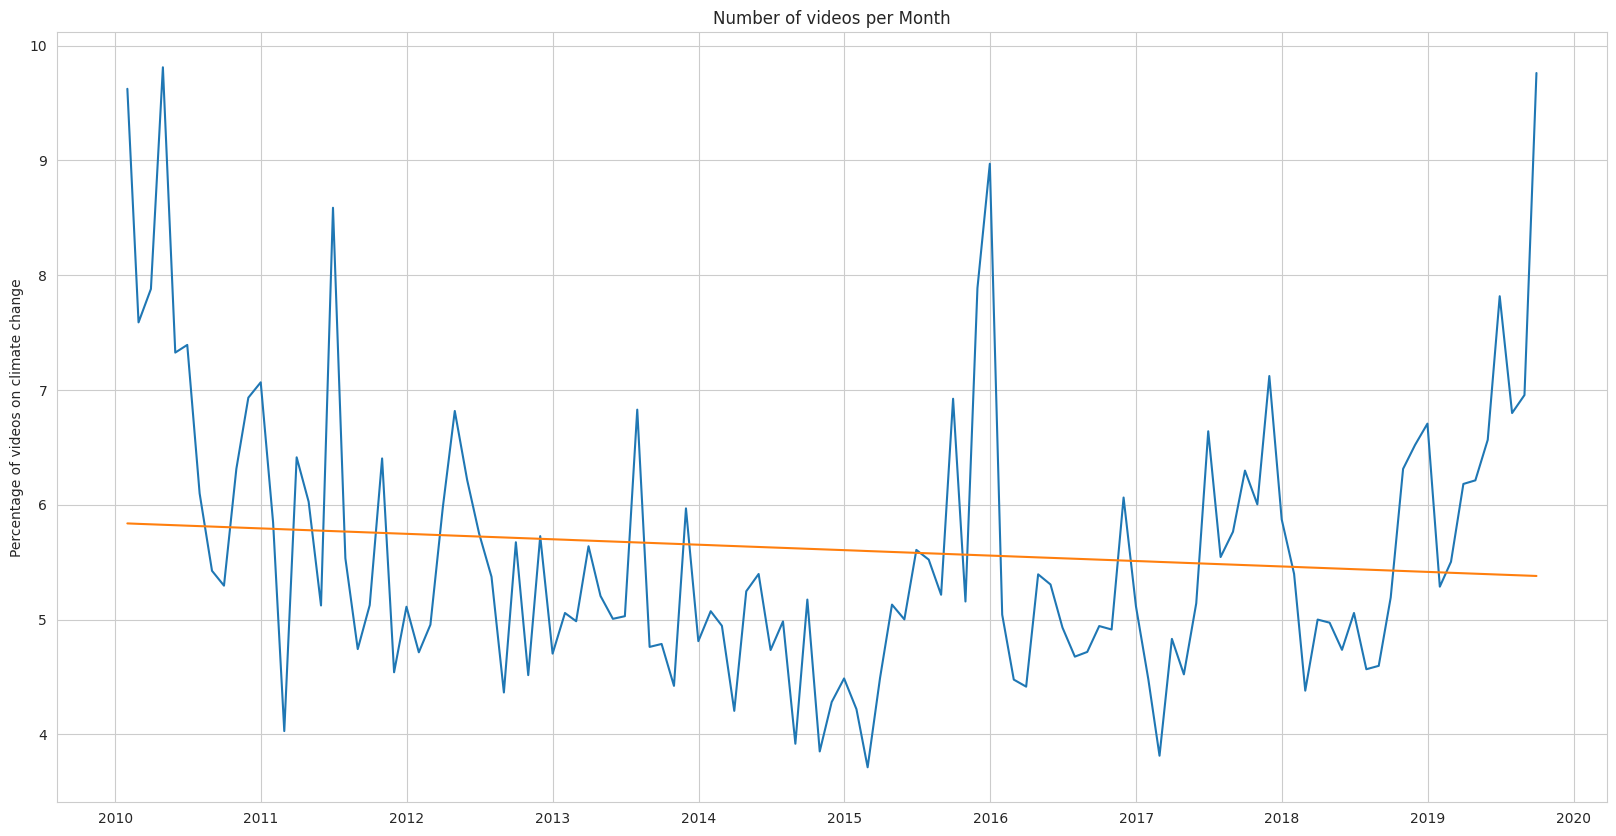

In [42]:
# Create count per month and count per week
count_per_month = count_per_day.resample('M').sum()
count_per_week = count_per_day.resample('W').sum()


# Aggregate the views and counts per day, week and month
sample_rate = ['Day', 'Week', 'Month']
counts = [count_per_day, count_per_week, count_per_month]

def plot_linear_fit(series: pd.Series):
    x = np.arange(len(series))
    y = series.values.tolist()
    
    # Perform linear regression (degree-1 polynomial)
    coefficients = np.polyfit(x, y, 1)
    linear_fit = np.poly1d(coefficients)
    
    # Generate points for the fitted line
    x_fit = np.linspace(x.min(), x.max(), len(series))
    y_fit = linear_fit(x_fit)
    return y_fit

# Plot the counts and views for each sample rate
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.plot(counts[i].index, counts[i].values)
    y_fit = plot_linear_fit(counts[i])
    ax.plot(counts[i].index, y_fit)
    ax.set_title(f'Number of videos per {sample_rate[i]}')
    ax.set_ylabel('Percentage of videos on climate change')
    plt.show()

In [43]:
# Extract maximum counts and view per week 
sorted_counts = count_per_week.sort_values(ascending=False)
amount = 4
print(f'The {amount} maximum number of videos per week is\n{sorted_counts[:amount]}\n')

The 4 maximum number of videos per week is
upload_date
2015-12-06    3.420975
2011-06-05    3.195969
2019-09-29    3.070066
2010-01-31    3.013900
dtype: float64


# Load the climate event dataset generated with ChatGPT

In [44]:
climate_events = pd.read_csv('data/climate_events.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])
climate_events.set_index('date', inplace=True)
climate_events.sort_index(inplace=True)
climate_events = climate_events.loc['2010': '2019-09-28']
climate_events.head()

,name_of_event
date,
2010-01-12,Haiti Earthquake and Its Impact on Vulnerable ...
2010-02-27,Madeira Floods: Flash Flooding and Urban Vulne...
2010-04-20,Deepwater Horizon Oil Spill
2010-07-06,Russia Wildfires and the Role of Forest Manage...
2010-07-07,Mumbai Floods: Urban Flooding and Climate Adap...


# Find important events according to the number of uploaded videos

In [45]:
data_countw = counts[1].resample('D').mean().fillna(method='ffill')
important_dates = list(climate_events.index)
important_dates = sorted(important_dates, key=lambda x: data_countw.loc[x], reverse=True)
important_dates = important_dates[:10]
print(important_dates)

[Timestamp('2015-12-12 00:00:00'), Timestamp('2019-09-23 00:00:00'), Timestamp('2010-04-20 00:00:00'), Timestamp('2015-12-20 00:00:00'), Timestamp('2011-04-27 00:00:00'), Timestamp('2017-12-04 00:00:00'), Timestamp('2010-02-27 00:00:00'), Timestamp('2010-01-12 00:00:00'), Timestamp('2012-11-05 00:00:00'), Timestamp('2017-09-20 00:00:00')]


/tmp/ipykernel_35751/1610225661.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_countw = counts[1].resample('D').mean().fillna(method='ffill')


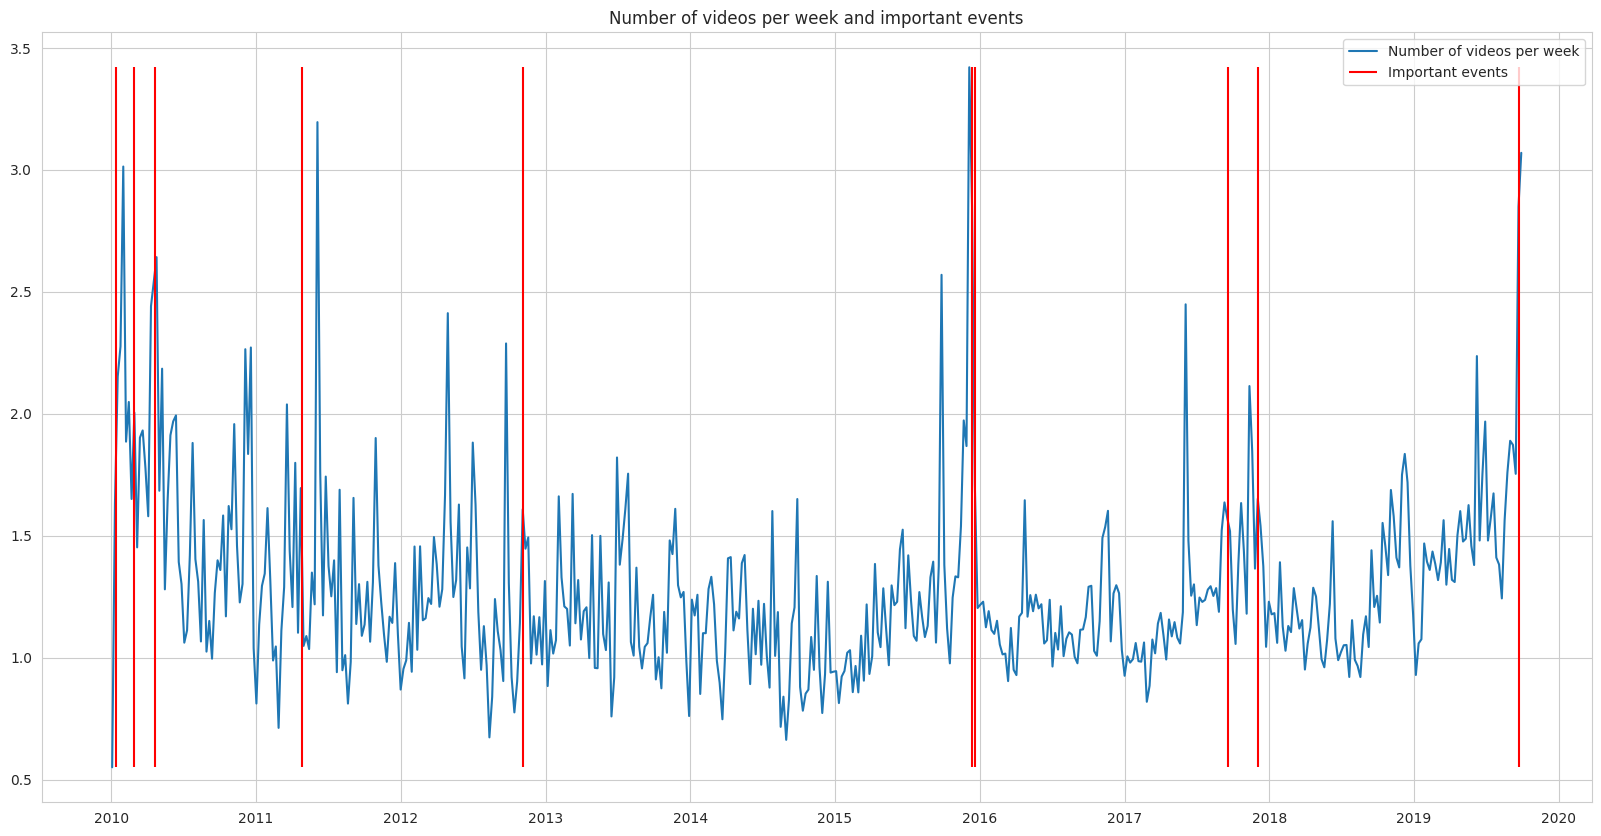

In [46]:
fig = plt.figure(figsize=(20, 10))
plt.plot(counts[1], label="Number of videos per week")
plt.vlines(important_dates, ymin=counts[1].min(), ymax=counts[1].max(), colors='r', label="Important events")
plt.title('Number of videos per week and important events')
plt.legend()
plt.show()

# Show the most important event according to the number of uploaded videos

In [47]:
print("The event with the highest spike corresponds to:")
print(f"{climate_events.loc[important_dates[0]].values[0]} on the {important_dates[0]}")

The event with the highest spike corresponds to:
Paris Agreement Adopted at COP21 on the 2015-12-12 00:00:00
